In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mnist_utils as mu
import random
import pyNN.nest as p
import relu_utils as alg
import spiking_relu as sr
import copy

In [2]:
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 1.,
                   'tau_syn_E': 1.0,
                   'tau_syn_I': 1.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }

In [3]:
def noiseI(x, stdnoise, cell_params_lif):
    p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
    run_s = 10.
    runtime = 1000. * run_s
    max_rate = 1000.
    #step = .1
    #x = np.arange(0., 1., step)
    count = 0
    pop_list=[]
    for i in x:
        noise = p.NoisyCurrentSource(mean=i, stdev=stdnoise, start=0, stop=runtime, dt=1.0,rng=p.NativeRNG(seed=0))
        pop = p.Population(1, p.IF_curr_exp, cell_params_lif)
        noise.inject_into(pop)
        pop_list.append(pop)
        pop.record()
        count += 1
    p.run(runtime)
    rate_I = np.zeros(count)
    for i in range(count):
        spikes = pop_list[i].getSpikes(compatible_output=True)
        rate_I[i] = len(spikes)/run_s
    p.end()
    return rate_I

In [27]:
def softplus(x, xscale=3.):
    a = 0.2
    b = 5.
    y = a * np.log(1.+ np.exp(x * b * xscale))
    #y = np.log(1.+np.exp(x*10.))
    return y

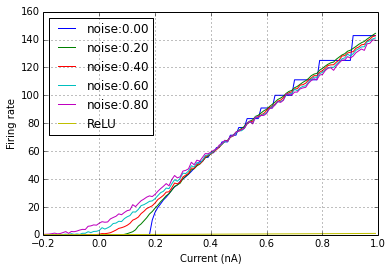

In [5]:
step = .01
x = np.arange(-0.2, 1., step)
rate_list=[]
for stdnoise in np.arange(0.,1.,0.2):
    rate = noiseI(x, stdnoise,cell_params_lif)
    rate_list.append(rate)
    plt.plot(x, rate, label='noise:%.2f'%stdnoise,)
plt.grid('on')

plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.plot(x, softplus(x), label='ReLU')
plt.legend(loc='upper left') #, shadow=True
#plt.savefig('noise.pdf')


49.6630053015


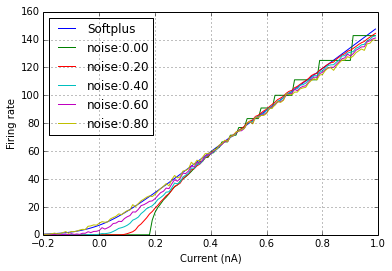

In [28]:
plt.clf()
scale = rate_list[2][70]/(softplus(x[70]))
print scale
plt.plot(x, softplus(x)*scale, label='Softplus')
for i in range(len(rate_list)):
    plt.plot(x, rate_list[i], label='noise:%.2f'%(i*0.2),)
plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.legend(loc='upper left') #, shadow=True

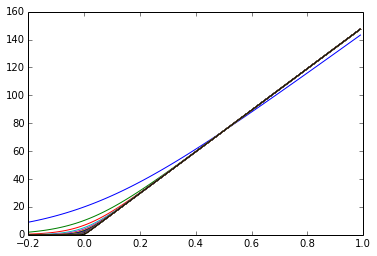

In [26]:
for xscale in range(1,50):
    scale = rate_list[2][70]/(softplus(x[70], xscale))
    plt.plot(x, softplus(x,xscale)*scale)

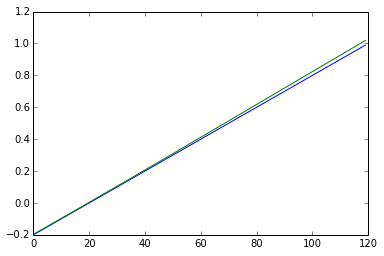

In [24]:
temp_x = x*10.
temp_y = np.log(1.+np.exp(x*10.))*scale
temp_x2 = 1./10. * np.log(np.exp(1./14.*temp_y)-1)
plt.plot(x)
plt.plot(temp_x2)

In [ ]:
def estimate_noise_kb (cell_params_lif):
    step = .01
    x = np.arange(-0.2, 1., step)
    stdnoise = 0.6
    rate = noiseI(x, stdnoise, cell_params_lif)
    x1 = 0.4
    x0 = np.where(rate>1.)[0][0]

In [17]:
def estimate_kb(cell_params_lif):
    cell_para = copy.deepcopy(cell_params_lif)
    random.seed(0)
    p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
    run_s = 10.
    runtime = 1000. * run_s
    max_rate = 1000.
    ee_connector = p.OneToOneConnector(weights=1.0, delays=2.0)    


    pop_list = []
    pop_output = []
    pop_source = []
    step = .01
    x = np.arange(0., 0.41, step)
    count = 0
    trail = 1

    for i in x:
        for j in range(trail): #trails for average
            pop_output.append(p.Population(1, p.IF_curr_exp, cell_para))
            poisson_spikes = mu.poisson_generator(i*max_rate, 0, runtime)
            pop_source.append( p.Population(1, p.SpikeSourceArray, {'spike_times' : poisson_spikes}) )
            p.Projection(pop_source[count], pop_output[count], ee_connector, target='excitatory')
            pop_output[count].record()
            count += 1


    count = 0
    for i in x:
        cell_para['i_offset'] = i
        pop_list.append(p.Population(1, p.IF_curr_exp, cell_para))
        pop_list[count].record()
        count += 1
    pop_list[count-1].record_v()

    p.run(runtime)

    rate_I = np.zeros(count)
    rate_P = np.zeros(count)
    rate_P_max = np.zeros(count)
    rate_P_min = np.ones(count) * 1000.
    for i in range(count):
        spikes = pop_list[i].getSpikes(compatible_output=True)
        rate_I[i] = len(spikes)/run_s
        for j in range(trail):
            spikes = pop_output[i*trail+j].getSpikes(compatible_output=True)
            spike_num = len(spikes)/run_s
            rate_P[i] += spike_num
            if spike_num > rate_P_max[i]:
                rate_P_max[i] = spike_num
            if spike_num < rate_P_min[i]:
                rate_P_min[i] = spike_num
        rate_P[i] /= trail
    
    #plot_spikes(spikes, 'Current = 10. mA')
    plt.plot(x, rate_I, label='current',)
    plt.plot(x, rate_P, label='Poisson input')
    plt.fill_between(x, rate_P_min, rate_P_max, facecolor = 'green', alpha=0.3)
    
    x0 = np.where(rate_P>1.)[0][0]
    x1 = 0.4/step
    k = (rate_P[x1] - rate_P[x0])/(x[x1]-x[x0])
    
    plt.plot(x, k*(x-x[x0])+rate_P[x0], label='linear')
    plt.legend(loc='upper left', shadow=True)
    plt.grid('on')
    plt.show()
    
    p.end()
    return k, x[x0], rate_P[x0]

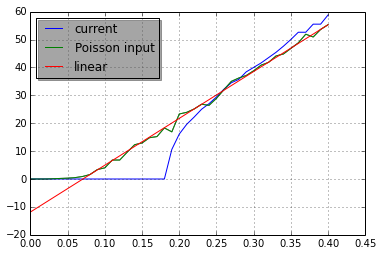

In [18]:
k, x0, y0 = estimate_kb(cell_params_lif)

In [6]:
def softplus(x):
    a = 0.2
    b = 0.5
    sfactor = 86.22
    y = sfactor * a * np.log(1.+ b * np.exp(x*10.))
    #y = 14.*np.log(1.+np.exp(output*10.))
    return y

def revers_softplus(x):
    #y = 1./10. * np.log(np.exp(1./14.*x)-1)
    a = 0.2
    b = 0.5
    sfactor = 86.22
    y = 1./10. * np.log((np.exp(x/(sfactor*a))-1.)/b)
    return y

[ -2.00000001e+00  -1.90000000e+00  -1.80000000e+00  -1.70000000e+00
  -1.60000000e+00  -1.50000000e+00  -1.40000000e+00  -1.30000000e+00
  -1.20000000e+00  -1.10000000e+00  -1.00000000e+00  -9.00000000e-01
  -8.00000000e-01  -7.00000000e-01  -6.00000000e-01  -5.00000000e-01
  -4.00000000e-01  -3.00000000e-01  -2.00000000e-01  -1.00000000e-01
   1.77635684e-15   1.00000000e-01   2.00000000e-01   3.00000000e-01
   4.00000000e-01   5.00000000e-01   6.00000000e-01   7.00000000e-01
   8.00000000e-01   9.00000000e-01   1.00000000e+00   1.10000000e+00
   1.20000000e+00   1.30000000e+00   1.40000000e+00   1.50000000e+00
   1.60000000e+00   1.70000000e+00   1.80000000e+00   1.90000000e+00]


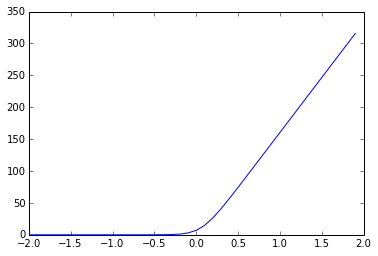

In [7]:
x=np.arange(-2,2,0.1)
y = softplus(x)
plt.plot(x,y)
z = revers_softplus(y)
print z

In [12]:
revers_softplus(50)

0.35360858556998648